In [1]:
!pip install pyclustering

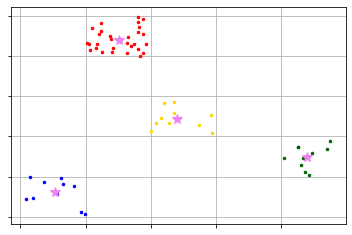

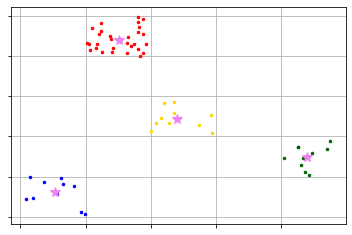

In [2]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES

# Read sample 'simple3' from file.
sample = read_sample(SIMPLE_SAMPLES.SAMPLE_SIMPLE3)

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(sample, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(sample, initial_centers, 20)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

# Visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show()

# Get pentad rainfall data

In [3]:
import numpy as np
import os

path = 'data/'
image_folder = 'CHIRPS_SPI_4pentads/'
lon = np.genfromtxt( path + "AOI_longitude.csv", delimiter=',')
lat = np.genfromtxt( path + "AOI_latitude.csv", delimiter=',')
    
files_raw = np.array(os.listdir(path + image_folder))
if '.DS_Store' in files_raw:    
    files = np.delete( files_raw, np.where(files_raw == '.DS_Store')[0][0] )
else:
    files = files_raw
files = np.sort(files)
ymp = [ (f.split('_')[1][1:5],  f.split('_')[1].split('m')[1].split('p')[0] ,
            f.split('_')[1].split('m')[1].split('p')[1])  for f in files]
image_arr = np.array([ np.genfromtxt( path + image_folder + f, delimiter=',') for f in files])
# image_arr_reshaped = np.transpose(image_arr, (1,2,0))

data_dict = {'latitude': lat,
        'longitude':lon,
        'imagearray': image_arr,
        'filenames':files,
        'ymp': ymp}

In [4]:
def normalize_array(data_array, transform = None, axis = 0):
    '''
    Parameters
    ----------
    data_array : 3-d numpy array 
        specifically a stack of rasters with time, lon (x), lat(y)
        data to get normalized
    
    transform: function(ndarray), (optional) :
        optional transformation function to apply across the data before transofrmation
        i.e. np.log10()
        
    axis: int or None, (optional) - default 0:
        aggregate mean and standard deviation over this axis
        select 0 to do a pixel-wise normalization
        select None to do a dataset-wide normalization
        

    Returns
    -------
    data_norm: a normalized version of that 3-d array, where every "image" in the time dimension is 
    normalized to 
    '''
    
    if transform != None:
        transformed_arr = transform(data_array)
    else:
        transformed_arr = data_array
    mean = np.nanmean(transformed_arr, axis = axis)
    std = np.nanstd(transformed_arr, axis = axis)
    data_norm = (transformed_arr - mean ) / std
    if data_norm.shape != data_array.shape:
        raise (ValueError)
    return data_norm

In [5]:
def log10_zerosnan(m):
    '''
    function which applies the numpy log10 to an array, keeping zeros set to 0
    '''
    o = np.empty_like(m)
    o[:] = np.nan
    return np.log10(m, out=o, where=(m!=0))

In [6]:
normalized_arr = normalize_array(data_dict['imagearray'],
                                  transform = log10_zerosnan)
normalized_arr[np.isnan(normalized_arr)] = 0
X = normalized_arr
# X = aggregate_yearly(data_dict)
X_2d = X.reshape((-1,X.shape[0]))

/var/folders/86/dsskgdwx0rx3sqjjl0kpv4wm0000gn/T/ipykernel_32896/2011796476.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(m, out=o, where=(m!=0))


In [7]:
data_dict['imagearray'].shape

(3000, 48, 59)

# Run k-means

In [8]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [9]:
def prepare_data(data_dict,method):
    aggregation_window = 4
    arr_t = data_dict['imagearray'].transpose(1,2,0)
    spi_arr = compute_spi( arr_t, agg_window = aggregation_window )[:,:,aggregation_window:-aggregation_window]
    w, h, d = original_shape = tuple(spi_arr.shape)
    assert d == 3000 - (2* aggregation_window)
    X = np.reshape(spi_arr, (w * h, d))
    return X, (w,h,d)

In [10]:
def run_kmeans(X,k):
    # declare 
    kmeans = KMeans(n_clusters=k, # Number of clusters to form
            init='k-means++', # Method for initialization: 
              # ‘k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence, and is theoretically proven to be -optimal. See the description of n_init for more details.
            n_init=20, # Number of time the k-means algorithm will be run with different centroid seeds. Result is best output in terms of inertia
            max_iter=1000, # Maximum number of iterations of the k-means algorithm for a single run.
            tol=0.0001, #Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.
            verbose=0, # Verbosity mode
            random_state=0, 
            copy_x=True, 
            algorithm='full'# K-means algorithm to use. The classical EM-style algorithm is "full"
            )
        
    # # fit algorithm
    labels = kmeans.fit_predict(X)

    return kmeans

In [11]:
def filter_by_month(data_dict, months):
    '''
    
    filters data dict by month
    
    Parameters
    ----------
    data_dict : data dict created by return_data

    months : array type
        months to include in analysis

    Returns
    -------
    updated_data_dict:
        data dict with only selected months' data

    '''
    ymp = np.array(data_dict['ymp'])[:,1].astype(int)
    selected_months = np.isin(ymp, months)
    updated_data_dict = {}
    updated_data_dict['latitude'] = data_dict['latitude']
    updated_data_dict['longitude'] = data_dict['longitude']
    updated_data_dict['imagearray'] = data_dict['imagearray'][selected_months,:,:]
    updated_data_dict['ymp'] = np.array(data_dict['ymp'])[selected_months]
    updated_data_dict['filenames'] = np.array(data_dict['filenames'])[selected_months]
    
    return updated_data_dict

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

k = 4
test = 'spi'

method = 'customdatadict'
spi_window = 4
#data_dict = return_data(mode = 'spi', spi_window = spi_window)
for key in ['imagearray', 'filenames', 'ymp']:
    data_dict[key] = data_dict[key][spi_window:-spi_window]
    
select_months = [2,3,4,5,6,7,8,9] #Feb to Sept
data_dict = filter_by_month(data_dict, select_months)

X, shape_tuple = prepare_data(data_dict,method)
w,h,d = shape_tuple
kmeans = run_kmeans(X,k)
#gmm = run_gmm(X, k) 

# colormap
cmap = ListedColormap(['tab:red','tab:blue','tab:green','tab:orange'])

def plot_map(cmap = cmap):
    def get_extent(data_dict):
        x_min, x_max = data_dict['longitude'].min(), data_dict['longitude'].max()
        y_min, y_max = data_dict['latitude'].min(), data_dict['latitude'].max()
        extent = [x_min , x_max, y_min , y_max]
        return extent
    labels = kmeans.labels_
    #labels = gmm.predict(X)
    im = plt.imshow(labels.reshape(w,h) ,
                cmap= cmap, 
                interpolation='None', extent = get_extent(data_dict))
    # get the colors of the values, according to the 
    # colormap used by imshow
    values = np.unique(labels)
    colors = [ im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    
    plt.show()

plot_map()

NameError: name 'compute_spi' is not defined

# run X means

In [13]:
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X, initial_centers, tolerance=0.001)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

ValueError: could not broadcast input array from shape (59,3000) into shape (3000,)

In [ ]:
def plot_map2(cmap = cmap):
    def get_extent(data_dict):
        x_min, x_max = data_dict['longitude'].min(), data_dict['longitude'].max()
        y_min, y_max = data_dict['latitude'].min(), data_dict['latitude'].max()
        extent = [x_min , x_max, y_min , y_max]
        return extent
    labels = xmeans_labels
    #labels = gmm.predict(X)
    im = plt.imshow(labels.reshape(w,h) , 
                interpolation='None', extent = get_extent(data_dict))
    # get the colors of the values, according to the 
    # colormap used by imshow
    values = np.unique(labels)
    colors = [ im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    
    plt.show()

In [ ]:
plot_map2()

In [ ]:
from pyclustering.cluster.xmeans import splitting_type

# see criteria at each split
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X, initial_centers, 1000, tolerance = 0.001, splitting_type=splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
xmeans_labels = np.zeros(len(X))
for i in range(len(clusters)):
    for idx in clusters[i]:
        xmeans_labels[idx] = i
plot_map2()

In [ ]:
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X, initial_centers, 2)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
xmeans_labels = np.zeros(len(X))
for i in range(len(clusters)):
    for idx in clusters[i]:
        xmeans_labels[idx] = i
plot_map2()

# Run PCA

In [ ]:
# component loading , 1 map per
# 1 map, 2-3 components
from sklearn.decomposition import PCA
pca = PCA(n_components=3).fit_transform(X)
pca

In [ ]:
len(xmeans_labels)

In [ ]:
def plot_map3(cmap = cmap):
    def get_extent(data_dict):
        x_min, x_max = data_dict['longitude'].min(), data_dict['longitude'].max()
        y_min, y_max = data_dict['latitude'].min(), data_dict['latitude'].max()
        extent = [x_min , x_max, y_min , y_max]
        return extent
    colors = ["Blues", "Greys", "Purples"]
    for i in range(3):
        labels = pca[:, i]
        #labels = gmm.predict(X)
        im = plt.imshow(labels.reshape(w,h),
                    cmap= colors[i], 
                    interpolation='None', extent = get_extent(data_dict))
        # get the colors of the values, according to the 
        # colormap used by imshow
        values = np.unique(labels)
        #colors = [ im.cmap(im.norm(value)) for value in values]
        # create a patch (proxy artist) for every color 
        #patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
        # put those patched as legend-handles into the legend
        #plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

        plt.show()

In [ ]:
pca

In [ ]:
plot_map3()

In [ ]:
pca.explained_variance_

# Run G-Means

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.gmeans import gmeans

gmeans_instance = gmeans(X, repeat=5, tolerance=100000000000000).process()
# Extract clustering results: clusters and their centers
clusters = gmeans_instance.get_clusters()
centers = gmeans_instance.get_centers()
gmeans_labels = np.zeros(len(X))
for i in range(len(clusters)):
    for idx in clusters[i]:
        gmeans_labels[idx] = i
        
def get_extent(data_dict):
    x_min, x_max = data_dict['longitude'].min(), data_dict['longitude'].max()
    y_min, y_max = data_dict['latitude'].min(), data_dict['latitude'].max()
    extent = [x_min , x_max, y_min , y_max]
    return extent
labels = gmeans_labels
#labels = gmm.predict(X)
im = plt.imshow(labels.reshape(w,h) , 
            interpolation='None', extent = get_extent(data_dict))
# get the colors of the values, according to the 
# colormap used by imshow
values = np.unique(labels)
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.gmeans import gmeans

gmeans_instance = gmeans(X, repeat=5, tolerance=100000000000000).process()
# Extract clustering results: clusters and their centers
clusters = gmeans_instance.get_clusters()
centers = gmeans_instance.get_centers()
gmeans_labels = np.zeros(len(X))
for i in range(len(clusters)):
    for idx in clusters[i]:
        gmeans_labels[idx] = i
        
def get_extent(data_dict):
    x_min, x_max = data_dict['longitude'].min(), data_dict['longitude'].max()
    y_min, y_max = data_dict['latitude'].min(), data_dict['latitude'].max()
    extent = [x_min , x_max, y_min , y_max]
    return extent
labels = gmeans_labels
#labels = gmm.predict(X)
im = plt.imshow(labels.reshape(w,h) , 
            interpolation='None', extent = get_extent(data_dict))
# get the colors of the values, according to the 
# colormap used by imshow
values = np.unique(labels)
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

In [ ]:
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(digitsdata['target_names']))
plt.show()

In [ ]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

In [ ]:
# g means